In [137]:
# Default imports 
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.integrate import quad as integrate
from scipy.stats import norm
import math
import random
from math import e, sqrt, pi
inf = float("inf")
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from gaussian_mixture_grid import GaussianMixtureGrid
import numpy as np
import pymc3 as pm
import matplotlib.cm as cm

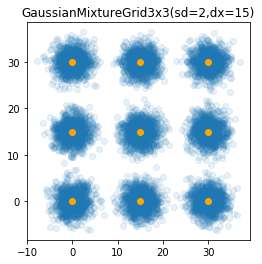

In [2]:
gri2d = GaussianMixtureGrid(length=3, dimensionality=2, spacing=15, stddev=2) 
# spacing 10 -- works well
# spacing 30 -- only finds one mode
plt.figure(figsize=(4,4))
plt.title(gri2d.name)
plt.scatter(*gri2d.sample(10000).T, alpha=0.1)
plt.scatter(*gri2d.means.T, c='orange')
plt.show()

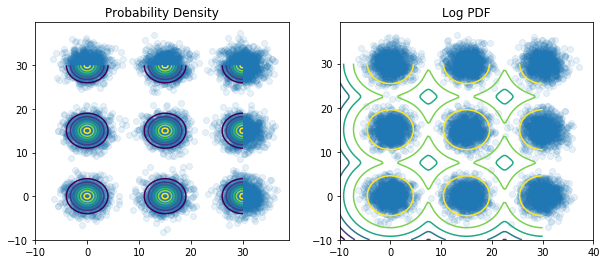

In [3]:
s = np.linspace(-10,30,100)
X,Y = np.meshgrid(s,s)
Z = [[gri2d.logp([x,y]) for x in s] for y in s]

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Probability Density')
plt.scatter(*gri2d.sample(10000).T, alpha=0.1)
plt.contour(X,Y,np.exp(Z))
plt.subplot(122)
plt.title('Log PDF')
plt.contour(X,Y,Z)
plt.scatter(*gri2d.sample(10000).T, alpha=0.1)
plt.show()

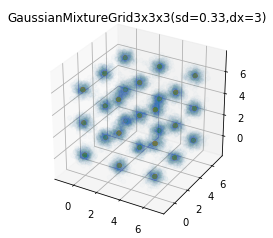

In [4]:
gri3d = GaussianMixtureGrid(3, 3, 3, 0.33)
X, Y, Z = gri3d.sample(10000).T
Xu, Yu, Zu = gri3d.means.T

ax = plt.figure(figsize=(4,4)).add_subplot(111, projection='3d')
plt.title(gri3d.name)
ax.scatter(X, Y, zs=Z, alpha=0.01)
ax.scatter(Xu, Yu, zs=Zu, c='orange')
plt.show()

# HMC vs Nuts vs Metropolis

In [5]:
N_SAMPLES = 50000
N_JOBS = 1

# NUTS
with pm.Model() as model_nuts:
  mix_nuts = gri2d.to_pymc()
  trace_nuts = pm.sample(N_SAMPLES)
    

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -2.2116: 100%|██████████| 200000/200000 [00:22<00:00, 8699.12it/s] 
Finished [100%]: Average ELBO = -2.2095
Evidence of divergence detected, inspect ELBO.
100%|██████████| 50000/50000 [00:41<00:00, 1191.64it/s]


In [6]:
# METROPOLIS
with pm.Model() as model_metropolis:
    # generalize start
    mix_metropolis = gri2d.to_pymc()
    trace_metropolis = pm.sample(N_SAMPLES, step=pm.Metropolis(tune=False), progressbar=True, njobs=N_JOBS)    

/usr/local/lib/python3.6/site-packages/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
100%|██████████| 50000/50000 [00:11<00:00, 4310.26it/s]


In [7]:
# Now with HMC
with pm.Model() as model_HMC:
    # generalize start
    mix_HMC = gri2d.to_pymc()
    trace_HMC = pm.sample(N_SAMPLES, step=pm.HamiltonianMC(), progressbar=True, njobs=N_JOBS)    

/usr/local/lib/python3.6/site-packages/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
100%|██████████| 50000/50000 [00:31<00:00, 1578.13it/s]


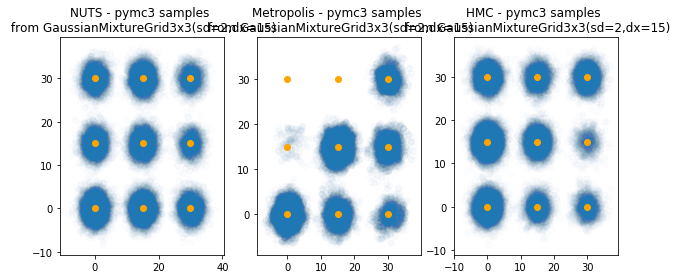

In [8]:
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title('NUTS - pymc3 samples \n from {}'.format(gri2d))
plt.scatter(*trace_nuts[gri2d.name].T, alpha=0.01)
plt.scatter(*gri2d.means.T, c='orange')

plt.subplot(1,3,2)
plt.title('Metropolis - pymc3 samples \n from {}'.format(gri2d))
plt.scatter(*trace_metropolis[gri2d.name].T, alpha=0.01)
plt.scatter(*gri2d.means.T, c='orange')

plt.subplot(1,3,3)
plt.title('HMC - pymc3 samples \n from {}'.format(gri2d))
plt.scatter(*trace_HMC[gri2d.name].T, alpha=0.01)
plt.scatter(*gri2d.means.T, c='orange')


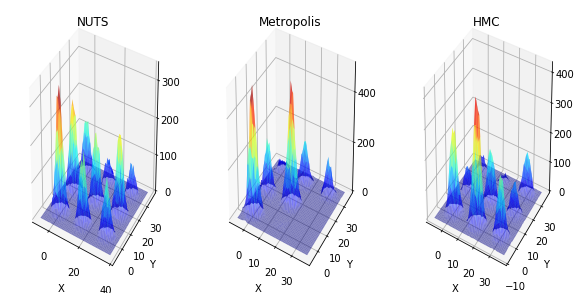

In [9]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1, 3, 1, projection='3d')

H, xbins, ybins = np.histogram2d(*trace_nuts[gri2d.name].T, bins=50)
X, Y = np.meshgrid(xbins[1:], ybins[1:])
ax.plot_surface(X, Y, H, cmap=cm.jet, alpha=.5)
# ax.plot_surface(X, Y, H, cmap=cm.jet, alpha=.7, rstride=20, cstride=20)
ax.set_title("NUTS")
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax = fig.add_subplot(1, 3, 2, projection='3d')
H, xbins, ybins = np.histogram2d(*trace_metropolis[gri2d.name].T, bins=50)
X, Y = np.meshgrid(xbins[1:], ybins[1:])
ax.plot_surface(X, Y, H, cmap=cm.jet, alpha=.5)
# ax.plot_surface(X, Y, H, cmap=cm.jet, alpha=.7, rstride=20, cstride=20)
ax.set_title("Metropolis")
ax.set_xlabel("X")
ax.set_ylabel("Y")


ax = fig.add_subplot(1, 3, 3, projection='3d')
H, xbins, ybins = np.histogram2d(*trace_HMC[gri2d.name].T, bins=50)
X, Y = np.meshgrid(xbins[1:], ybins[1:])
ax.plot_surface(X, Y, H, cmap=cm.jet, alpha=.5)
# ax.plot_surface(X, Y, H, cmap=cm.jet, alpha=.7, rstride=20, cstride=20)
ax.set_title("HMC")
ax.set_xlabel("X")
ax.set_ylabel("Y")




# Diagnostics

Sources:

* https://pymc-devs.github.io/pymc3/api/diagnostics.html
* https://pymc-devs.github.io/pymc3/api/plots.html
* http://rlhick.people.wm.edu/stories/bayesian_5.html
        

# Plots on offer

## 1. Posterior marginals - we would want each mode to be equally represented

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11e7585f8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11d2f3550>], dtype=object)

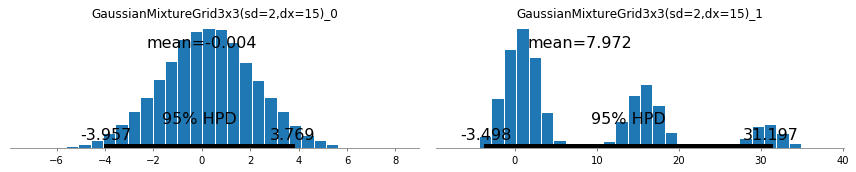

In [70]:
pm.plots.plot_posterior(trace_metropolis)

## 2. Traceplot - posterior marginals again with the trace

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1226f86a0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x125a86a90>]], dtype=object)

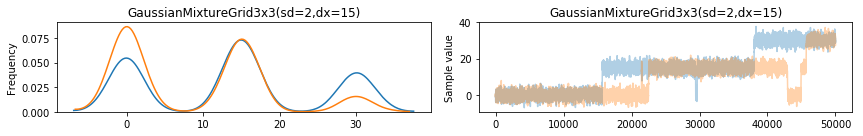

In [10]:
pm.plots.traceplot(trace_metropolis)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11783b240>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11d83ef28>]], dtype=object)

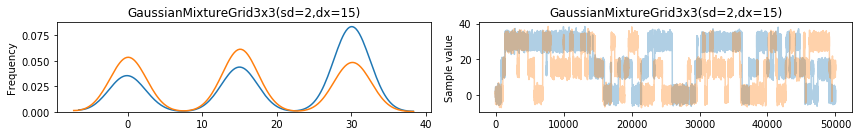

In [72]:
pm.plots.traceplot(trace_nuts)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1266b5978>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x126dcd4e0>]], dtype=object)

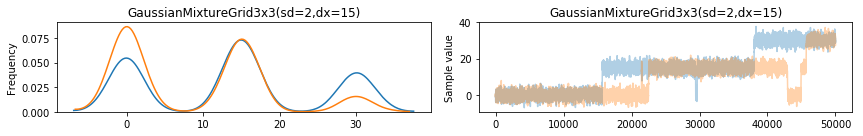

In [14]:
pm.plots.traceplot(trace_metropolis)

## 3. Forestplot - don't think this one is useful to us

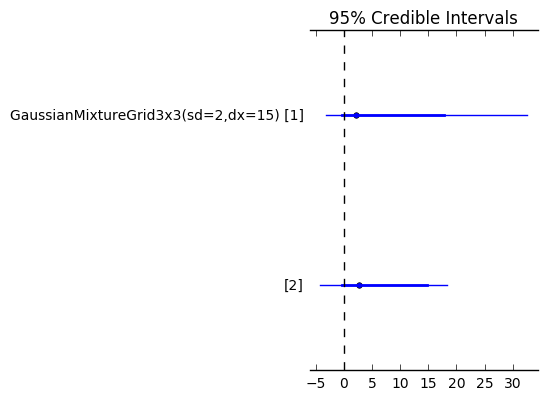

In [160]:
pm.plots.forestplot(trace_metropolis)

# Diagnostics

## 1. Autocorrelation goes down if you thin *alot*

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x125da9940>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x1264993c8>]], dtype=object)

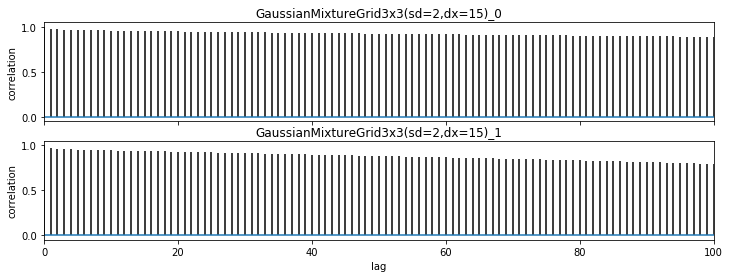

In [12]:
pm.plots.autocorrplot(trace_metropolis[1000::10])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b9a9550>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x11d962358>]], dtype=object)

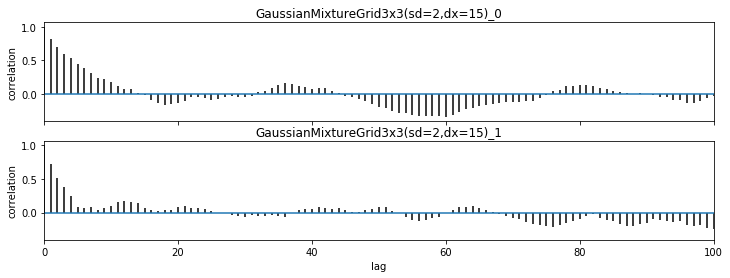

In [76]:
pm.plots.autocorrplot(trace_nuts[1000::250])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ad64e48>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x11dfbde48>]], dtype=object)

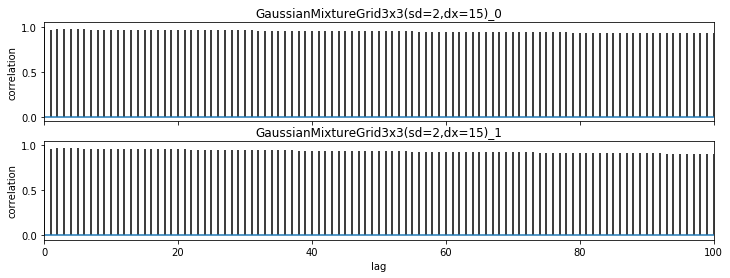

In [79]:
pm.plots.autocorrplot(trace_HMC)

## This seems sketchy. Doesn't match up with what we'd expect given traceplots above.


## 2. Geweke

* If we have adequately culled the burnin expect to fail to reject the null that the mean for the first 10% and the mean of any interval in the last 50% is the same.

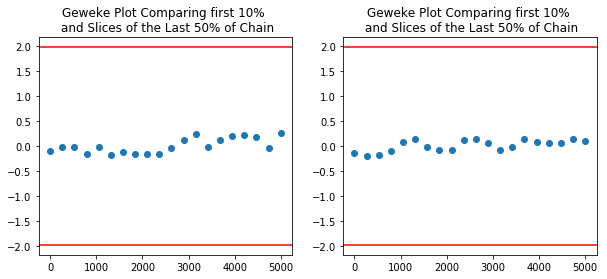

In [40]:
gw_plot = pm.geweke(trace_metropolis,.1,.5,20)

plt.figure(figsize=(10,4))
for dim, geweke_dim in enumerate(gw_plot[gri2d.name]):
    plt.subplot(1,2,dim+1)
    plt.scatter(*geweke_dim.T)
    plt.axhline(-1.98, c='r')
    plt.axhline(1.98, c='r')
    plt.title('Geweke Plot Comparing first 10% \n and Slices of the Last 50% of Chain')


## 3. Gelman-Rubin

In [227]:
# METROPOLIS
with pm.Model() as model_metropolis2:
    # generalize start
    mix_metropolis2 = gri2d.to_pymc()
    trace_metropolis2 = pm.sample(N_SAMPLES, step=pm.Metropolis(), progressbar=True, njobs=2)

100%|██████████| 10000/10000 [00:00<00:00, 11446.12it/s]


In [ ]:
pm.diagnostics.gelman_rubin(trace_metropolis2)

pymc3 bugged 
* https://github.com/pymc-devs/pymc3/issues/1033
* compares between and within chain variance, so needs multiple jobs. However, when you choose njobs>1 we run into a pymc3 bug.
* rule of thumb. want this as close to 1 as possible. in particular when this is greater than 1.1 a longer burn-in is needed.

## 4. Effective Sample Size

In [ ]:
pm.diagnostics.effective_n(trace_metropolis2)

* Also expects a multitrace so sadly bugged. 


## New Plots

In [84]:
trace_metropolis)

array([{'GaussianMixtureGrid3x3(sd=2,dx=15)': array([ 0.80439511, -0.4198281 ])},
       {'GaussianMixtureGrid3x3(sd=2,dx=15)': array([-0.77067692,  0.64074897])},
       {'GaussianMixtureGrid3x3(sd=2,dx=15)': array([-1.10911618, -1.23171544])},
       ...,
       {'GaussianMixtureGrid3x3(sd=2,dx=15)': array([ 29.86429709,  32.05872872])},
       {'GaussianMixtureGrid3x3(sd=2,dx=15)': array([ 29.86429709,  32.05872872])},
       {'GaussianMixtureGrid3x3(sd=2,dx=15)': array([ 29.86429709,  32.05872872])}], dtype=object)

In [107]:
def traceplot(trace, varnames=None, transform=identity_transform, figsize=None, lines=None,
              combined=False, plot_transformed=False, grid=False, alpha=0.35, priors=None,
              prior_alpha=1, prior_style='--', ax=None, live_plot=False,
              skip_first=0, refresh_every=100, roll_over=1000):
    """Plot samples histograms and values.
    Parameters
    ----------
    trace : result of MCMC run
    varnames : list of variable names
        Variables to be plotted, if None all variable are plotted
    transform : callable
        Function to transform data (defaults to identity)
    figsize : figure size tuple
        If None, size is (12, num of variables * 2) inch
    lines : dict
        Dictionary of variable name / value  to be overplotted as vertical
        lines to the posteriors and horizontal lines on sample values
        e.g. mean of posteriors, true values of a simulation.
        If an array of values, line colors are matched to posterior colors.
        Otherwise, a default red line
    combined : bool
        Flag for combining multiple chains into a single chain. If False
        (default), chains will be plotted separately.
    plot_transformed : bool
        Flag for plotting automatically transformed variables in addition to
        original variables (defaults to False).
    grid : bool
        Flag for adding gridlines to histogram. Defaults to True.
    alpha : float
        Alpha value for plot line. Defaults to 0.35.
    priors : iterable of PyMC distributions
        PyMC prior distribution(s) to be plotted alongside posterior. Defaults
        to None (no prior plots).
    prior_alpha : float
        Alpha value for prior plot. Defaults to 1.
    prior_style : str
        Line style for prior plot. Defaults to '--' (dashed line).
    ax : axes
        Matplotlib axes. Accepts an array of axes, e.g.:
    live_plot: bool
        Flag for updating the current figure while sampling
    skip_first : int
        Number of first samples not shown in plots (burn-in). This affects
        frequency and stream plots.
    refresh_every : int
        Period of plot updates (in sample number)
    roll_over : int
        Width of the sliding window for the sample stream plots: last roll_over
        samples are shown (no effect on frequency plots).
        >>> fig, axs = plt.subplots(3, 2) # 3 RVs
        >>> pymc3.traceplot(trace, ax=axs)
        Creates own axes by default.
    Returns
    -------
    ax : matplotlib axes
    """
    trace = trace[skip_first:]

    if varnames is None:
        varnames = get_default_varnames(trace, plot_transformed)

    if figsize is None:
        figsize = (12, len(varnames) * 2)

    ax = get_axis(ax, len(varnames), 2, squeeze=False, figsize=figsize)

    for i, v in enumerate(varnames):
        if priors is not None:
            prior = priors[i]
        else:
            prior = None
        first_time = True
        for d in trace.get_values(v, combine=combined, squeeze=False):
            d = np.squeeze(transform(d))
            d = make_2d(d)
            d_stream = d
            x0 = 0
            if live_plot:
                x0 = skip_first
                if first_time:
                    ax[i, 0].cla()
                    ax[i, 1].cla()
                    first_time = False
                if roll_over is not None:
                    if len(d) >= roll_over:
                        x0 = len(d) - roll_over + skip_first
                    d_stream = d[-roll_over:]
            width = len(d_stream)
            if d.dtype.kind == 'i':
                hist_objs = histplot_op(ax[i, 0], d, alpha=alpha)
                colors = [h[-1][0].get_facecolor() for h in hist_objs]
            else:
                artists = kdeplot_op(ax[i, 0], d, prior, prior_alpha, prior_style)[0]
                colors = [a[0].get_color() for a in artists]
            ax[i, 0].set_title(str(v))
            ax[i, 0].grid(grid)
            ax[i, 1].set_title(str(v))
            ax[i, 1].plot(range(x0, x0 + width), d_stream, alpha=alpha)

            ax[i, 0].set_ylabel("Frequency")
            ax[i, 1].set_ylabel("Sample value")

            if lines:
                try:
                    if isinstance(lines[v], (float, int)):
                        line_values, colors = [lines[v]], ['r']
                    else:
                        line_values = np.atleast_1d(lines[v]).ravel()
                        if len(colors) != len(line_values):
                            raise AssertionError("An incorrect number of lines was specified for "
                                                 "'{}'. Expected an iterable of length {} or to "
                                                 " a scalar".format(v, len(colors)))
                    for c, l in zip(colors, line_values):
                        ax[i, 0].axvline(x=l, color=c, lw=1.5, alpha=0.75)
                        ax[i, 1].axhline(y=l, color=c,
                                         lw=1.5, alpha=alpha)
                except KeyError:
                    pass
        if live_plot:
            for j in [0, 1]:
                ax[i, j].relim()
                ax[i, j].autoscale_view(True, True, True)
            ax[i, 1].set_xlim(x0, x0 + width)
        ax[i, 0].set_ylim(ymin=0)
    if live_plot:
        ax[0, 0].figure.canvas.draw()
    plt.tight_layout()
    return ax

NameError: name 'identity_transform' is not defined

In [106]:
axs = traceplot(trace_metropolis)

NameError: name 'traceplot' is not defined

In [33]:
ax[0][1]

In [60]:
type(fig)

matplotlib.figure.Figure

In [98]:
type(axs[])

matplotlib.axes._subplots.AxesSubplot

In [92]:
plt.axs.shape?

TypeError: inner() got multiple values for argument 'ax'

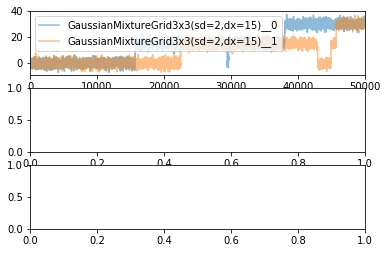

In [132]:
fig, axs = plt.subplots(3,1)
ax1,ax2,ax3 = axs
pm.trace_to_dataframe(trace_metropolis).plot(alpha=.5, ax=ax1)
plt.acorr(pm.trace_to_dataframe(trace_metropolis).ix[:,0], ax=ax2)
plt.acorr(pm.trace_to_dataframe(trace_metropolis).ix[:,1], ax=ax3)

In [126]:
pm.trace_to_dataframe(trace_metropolis).plot(alpha=.5, kind="acorr")

ValueError: 'acorr' is not a valid plot kind

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([ 0.99266246,  0.99315348,  0.99369465,  0.99427666,  0.9949032 ,
         0.99558115,  0.99633334,  0.99713923,  0.99801003,  0.99896067,
         1.        ,  0.99896067,  0.99801003,  0.99713923,  0.99633334,
         0.99558115,  0.9949032 ,  0.99427666,  0.99369465,  0.99315348,
         0.99266246]),
 <matplotlib.lines.Line2D at 0x1247754e0>)

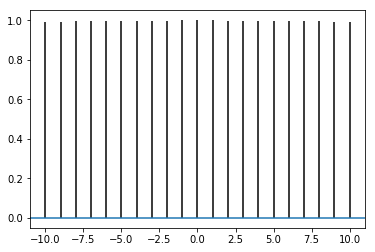

In [130]:
plt.acorr(pm.trace_to_dataframe(trace_metropolis).ix[:,0])

In [129]:
plt.acpm.trace_to_dataframe(trace_metropolis).ix[:,0]

0         0.804395
1        -0.770677
2        -1.109116
3        -2.087943
4        -1.681576
5        -1.681576
6        -1.681576
7        -1.344741
8        -1.306201
9        -0.197205
10       -1.147953
11       -1.900818
12       -2.548263
13       -2.548263
14       -2.915397
15       -2.915397
16       -3.306027
17       -3.622819
18       -3.622819
19       -3.622819
20       -3.425823
21       -1.445106
22        0.133621
23        0.568581
24        1.285077
25        1.285077
26        2.043173
27        2.043173
28        1.450264
29        2.032244
           ...    
49970    30.171430
49971    30.171430
49972    31.021255
49973    31.021255
49974    31.418218
49975    31.418218
49976    31.418218
49977    31.418218
49978    31.590069
49979    31.590069
49980    31.590069
49981    32.096316
49982    31.816671
49983    30.889991
49984    28.904350
49985    30.403455
49986    31.404741
49987    29.940428
49988    29.940428
49989    30.930602
49990    28.556426
49991    28.

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:2553: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([ 0.99266246,  0.99315348,  0.99369465,  0.99427666,  0.9949032 ,
         0.99558115,  0.99633334,  0.99713923,  0.99801003,  0.99896067,
         1.        ,  0.99896067,  0.99801003,  0.99713923,  0.99633334,
         0.99558115,  0.9949032 ,  0.99427666,  0.99369465,  0.99315348,
         0.99266246]),
 <matplotlib.lines.Line2D at 0x13994b550>)

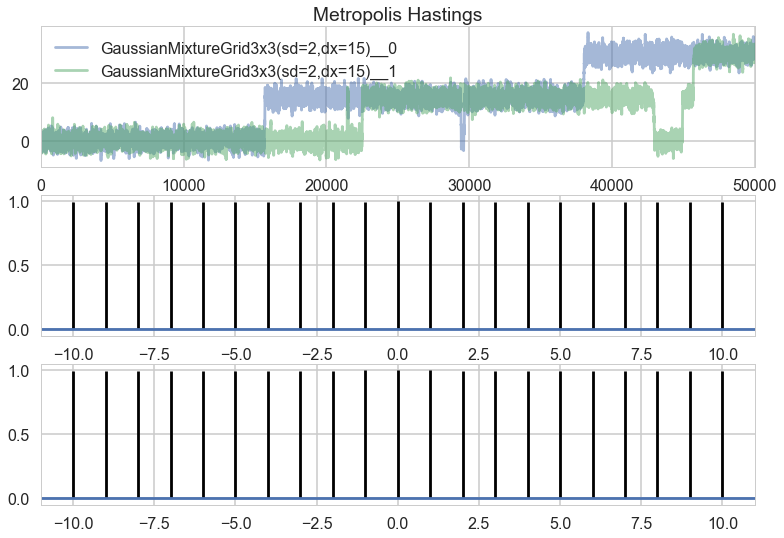

In [154]:
ax = plt.subplot(311)
plt.title("Metropolis Hastings")
pm.trace_to_dataframe(trace_metropolis).plot(alpha=.5, ax=ax)
plt.subplot(312)
plt.acorr(pm.trace_to_dataframe(trace_metropolis).ix[:,0],hold=100)
plt.subplot(313)
plt.acorr(pm.trace_to_dataframe(trace_metropolis).ix[:,0])

In [189]:
def corrplot(trace,title,maxlags=50):
    x1_trace,x2_trace = pm.trace_to_dataframe(trace).ix[:,0],pm.trace_to_dataframe(trace).ix[:,1]
    
    fig = plt.figure()
    
    ax1 = plt.subplot2grid((2,2), (0,0), colspan=2)
    ax4 = plt.subplot2grid((2,2), (1, 0))
    ax5 = plt.subplot2grid((2,2), (1, 1))
    
    ax1.title(title)
    pm.trace_to_dataframe(trace).plot(alpha=.5, ax=ax1)
    
    
    ax4.acorr(x1_trace-np.mean(x1_trace),  normed=True, maxlags=maxlags)
    ax4.set_xlim([0, maxlags])
    ax4.set_title("$X$ Corrplot")
    ax4.axhline(0, color='black', lw=2)


    #ax5 = fig.add_subplot(313, sharex=ax1,adjustable='box-forced')
    ax5.acorr(x2_trace-np.mean(x2_trace),  normed=True, maxlags=maxlags)
    ax5.set_xlim([0, maxlags])
    ax5.set_title("$Y$ Corrplot")
    ax5.axhline(0, color='black', lw=2)
    
    
    plt.show()

TypeError: 'Text' object is not callable

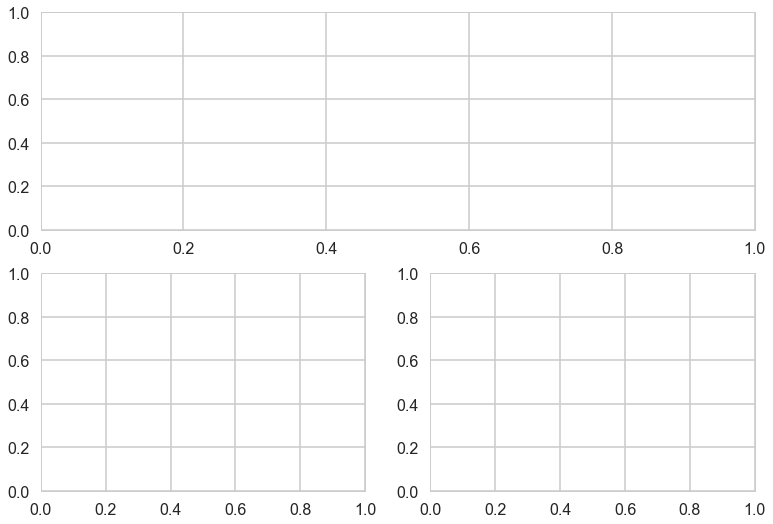

In [190]:
corrplot(trace_metropolis,"Metropolis Hastings – Trace and autocorrelation")